# Plagiarism detector

## Project Setup

To start the project, let's set the reference path of the notebook to the root of the project. In that way, it will be easier to deal with filepaths whenever necessary. Also, let's configure log level INFO message.

In [1]:
import os
import pathlib
path = os.path.join(pathlib.Path().absolute(), '../')
os.chdir(path)

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.INFO)

## Load and prepare the data

The first step of course is to load the data. The loading procedure involves iterating through the dataset folder and aggregating labels and records. In the project, for each candidate answer, there are 6 LLM answers and similarity scores between each LLM answer and the candidate answer.

So, we are going to approach this, as if we have 6 different records. For example, for the first code challenge question, we have the following structure:

```markdown
./dataset
├── CodeAid Source Codes Labeling.xlsx
├── dataset-source-codes
    ├── source_code_000
        ├── source_code_000.json
        ├── source_code_000.java
        ├── source_code_000_gpt-3.5-turbo_00.java
        ├── source_code_000_gpt-3.5-turbo_01.java
        ├── source_code_000_gpt-4_00.java
        ├── source_code_000_gpt-4_01.java
        ├── source_code_000_gpt-4-turbo_00.java
        ├── source_code_000_gpt-4-turbo_01.java
    
```

As you can see, for `source_code_000`, the candidate answer is in the `source_code_000.java`, while there are 6 gpt answers in the other files. Thus, what we meant previously was that we are going to structure the dataset for the problem not as a single datapoint, but as six. Therefore, the dataset records generated for the source_code_000, for example, is something in the lines of:

| candidate source code | LLM source code | plagiariasm score |
|-----------------------|-----------------|-------------------|
| source_code_000.java | source_code_000_gpt-3.5-turbo_00.java | 0.0 |
| source_code_000.java | source_code_000_gpt-3.5-turbo_01.java | 0.0 |
| source_code_000.java | source_code_000_gpt-4_00.java | 0.0 |
| source_code_000.java | source_code_000_gpt-4_01.java | 0.0 |
| source_code_000.java | source_code_000_gpt-4-turbo_00.java | 0.0 |
| source_code_000.java | source_code_000_gpt-4-turbo_01.java | 0.0 |

Ok, now we are in good shape to actually do that.

In [2]:
import os
import re
import json
import pandas as pd
from pandas import DataFrame
from typing import List, Dict, Any
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def read_file(file_path: str) -> str:
    with open(file_path, 'r') as file:
        return file.read()

def list_files_with_regex(folder_path: str, pattern: str) -> List[str]:
    matched_files = []
    regex = re.compile(pattern)

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if regex.match(file):
                matched_files.append(os.path.join(root, file))

    return matched_files

def load_data(dataset_path: str, label: DataFrame) -> Dict[str, Any]:
    data = {
        'coding_problem_id': [],
        'coding_question': [],
        'candidate_answer': [],
        'llm_answer_id': [],
        'llm_answer': [],
        'plagiarism_score': [],
        "programming_language": []
    }

    for index, row in tqdm(label.iterrows()):
        problem_id = row['coding_problem_id']
        llm_answer_id = row['llm_answer_id']
        plagiarism_score = row['plagiarism_score']

        folder = os.path.join(dataset_path, problem_id)

        json_file_path = os.path.join(folder, f'{problem_id}.json')
        with open(json_file_path, 'r') as json_file:
            coding_question = json.load(json_file)['question']

        # identify code file extensions
        pattern = fr'{problem_id}\..*'  # Example pattern
        matched_files = list_files_with_regex(folder, pattern)
        file_code_extension = [file.split(".")[-1] for file in matched_files if file.split(".")[-1] != "json"][0]

        candidate_base_path = os.path.join(folder, problem_id)
        candidate_file_path = f"{candidate_base_path}.{file_code_extension}"
        candidate_answer = read_file(candidate_file_path)

        # Find the LLM's code file with any of the possible extensions
        llm_base_path = os.path.join(folder, f'{problem_id}_{llm_answer_id}')

        llm_file_path = f"{llm_base_path}.{file_code_extension}"
        llm_answer = read_file(llm_file_path)

        data['coding_problem_id'].append(problem_id)
        data['coding_question'].append(coding_question)
        data['candidate_answer'].append(candidate_answer)
        data['llm_answer_id'].append(llm_answer_id)
        data['llm_answer'].append(llm_answer)
        data['plagiarism_score'].append(plagiarism_score)
        data["programming_language"].append(file_code_extension)

    return data

In [5]:
# Path to the dataset folder containing source codes
dataset_path = './dataset/dataset-source-codes'

# Load the labels from the Excel file
labels = pd.read_excel('./dataset/CodeAid Source Codes Labeling.xlsx', sheet_name='v3')

data = load_data(dataset_path, labels)

378it [00:00, 1043.60it/s]


Once, we've successfully load the data into the desired format, we can convert it to an appropriate format to huggingface models.

In [6]:
from datasets import Dataset, DatasetDict
dataset = DatasetDict({'data': Dataset.from_dict(data)})

In [7]:
dataset

DatasetDict({
    data: Dataset({
        features: ['coding_problem_id', 'coding_question', 'candidate_answer', 'llm_answer_id', 'llm_answer', 'plagiarism_score', 'programming_language'],
        num_rows: 378
    })
})

In [8]:
data_df = DataFrame(data)
data_df.tail()

,coding_problem_id,coding_question,candidate_answer,llm_answer_id,llm_answer,plagiarism_score,programming_language
373,source_code_062,Create a PHP script that will accept a string ...,<?php\nfunction getTopThreeWords($text) {\n// ...,gpt-3.5-turbo_01,<?php\n\nfunction findTopThreeWords($input) {\...,0.3,php
374,source_code_062,Create a PHP script that will accept a string ...,<?php\nfunction getTopThreeWords($text) {\n// ...,gpt-4_00,function findTopWords($input) {\n // Remove...,0.3,php
375,source_code_062,Create a PHP script that will accept a string ...,<?php\nfunction getTopThreeWords($text) {\n// ...,gpt-4_01,<?php\n function mostCommonWords($input) {\...,0.3,php
376,source_code_062,Create a PHP script that will accept a string ...,<?php\nfunction getTopThreeWords($text) {\n// ...,gpt-4-turbo_00,<?php\n\nfunction getTopThreeWords($text) {\n ...,0.3,php
377,source_code_062,Create a PHP script that will accept a string ...,<?php\nfunction getTopThreeWords($text) {\n// ...,gpt-4-turbo_01,<?php\n\n// Function to get the top three most...,0.3,php


### Data Analysis

As a warm up, let's do some quick data analysis just to know the dataset better. Usually, it's good practice to analyse the data over the training set to avoid "being too smart" and somehow get a glimpse of the evaluation dataset, which could potentially bias our analysis. However, since here we are going to use pre-trained models to accomplish our task and we have only a couple tens of records, let's make this exception.

First, let's count the frequency of programming languages per code challenge:

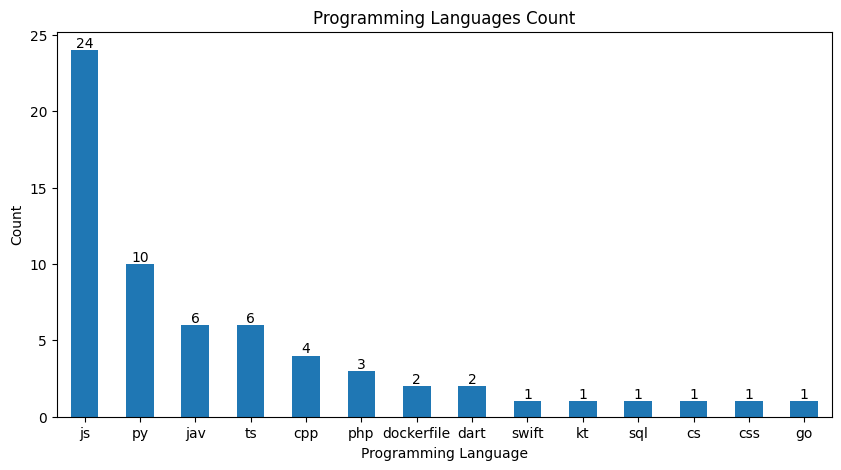

In [9]:
# dividing by 6 to account for duplicate programming language rows
programming_languages_counts = (data_df["programming_language"].value_counts() / 6).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

programming_languages_counts.plot(kind='bar', ax=ax)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.title('Programming Languages Count')
plt.xlabel('Programming Language')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The most frequent programming languages are JavaScript (plus TypeScript), Python, Java, C++, PHP. Other programming languages contributes very little to the volume of the dataset.

Let's shift gears and study the distribution of plagiarism scores:

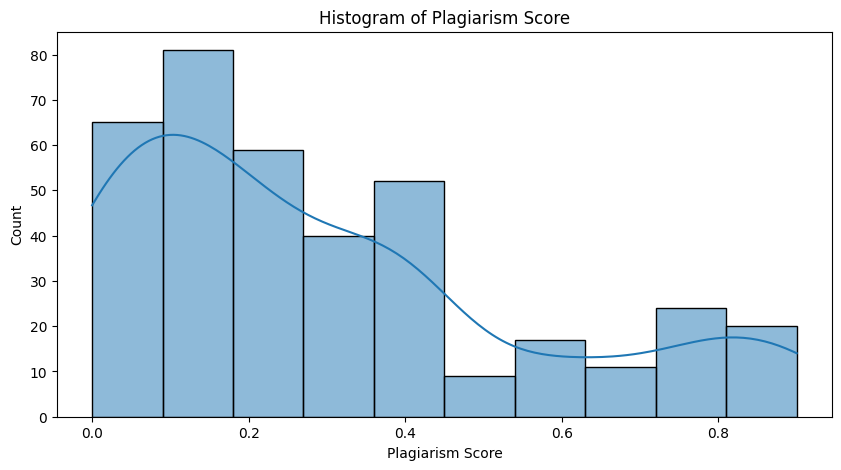

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.histplot(data=data_df, x='plagiarism_score', bins=10, discrete=False, kde=True, ax=ax)

plt.title('Histogram of Plagiarism Score')
plt.xlabel('Plagiarism Score')
plt.ylabel('Count')
plt.show()

As we can see, the labels are bimodal, and most of the times, the amount of potential plagiarism detected is slow. This might be a problem for the model we are going to develop later, because that indicates that there are only relatively few samples with strong signals. Thus, the model is going to have a harder time trying to read the data patterns.

Now, let's examine the data from the perspective of the size (in characters) of the answers provided by the candidates and the LLMs.

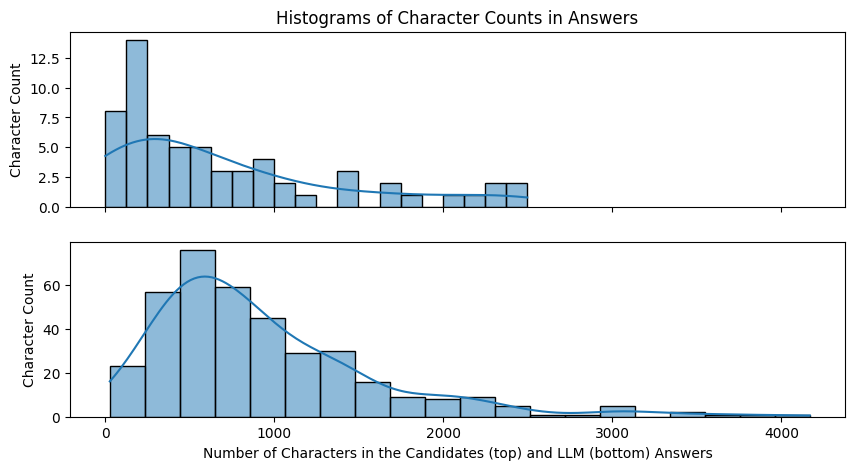

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

candidate_answer_len = data_df["candidate_answer"].drop_duplicates().apply(len).to_frame()
sns.histplot(data=candidate_answer_len, x='candidate_answer', bins=20, discrete=False, kde=True, ax=ax[0])

llm_answer_len = data_df["llm_answer"].drop_duplicates().apply(len).to_frame()
sns.histplot(data=llm_answer_len, x='llm_answer', bins=20, discrete=False, kde=True, ax=ax[1])

ax[0].set_title('Histograms of Character Counts in Answers')
ax[0].set_xlabel('')  # Remove x label for the first histogram

ax[0].set_ylabel('Character Count')

ax[1].set_xlabel('Number of Characters in the Candidates (top) and LLM (bottom) Answers')
ax[1].set_ylabel('Character Count')
plt.show()

As we can see, the answers provided by the LLMs tend to be bigger in character count. This may happen for some reasons such as code comments or docstrings. It also indicates that 1:1 correspondences between candidates answers and LLM answers may be unlikely.

Ok, now let's focus on building a plagiarism detector.

## Building a baseline model

Before properly tackling the problem, it's good practice to create a baseline model so we can compare it against the model we are going to obtain later. There isn't a closed formula for how to set baselines. It usually requires common sense and gut feeling. For our purposes here, it may be enough to do some cosine similarity between embeddings of the candidates and LLM answers. Let's see how it goes.

To vectorize the dataset, we are going to use a pre-trained model from HuggingFace. Of course, we could use any generic model, like BERT, for example, but conveniently there exist a pre-trained model for Programming and Natural Languages: `jina-embeddings-v2-base-code` (with 161 million parameters code embeddings)\[[1](https://arxiv.org/abs/2310.19923)\].

`jina-embeddings-v2-base-code` is an multilingual embedding model speaks English and 30 widely used programming languages. It is based on a Bert architecture (JinaBert) that supports the symmetric bidirectional variant of ALiBi\[[2](https://arxiv.org/abs/2108.12409)\] to allow longer sequence length. The backbone jina-bert-v2-base-code is pretrained on the github-code dataset\[[3](https://huggingface.co/datasets/codeparrot/github-code)\]. The model is further trained on Jina AI's collection of more than 150 millions of coding question answer and docstring source code pairs. These pairs were obtained from various domains and were carefully selected through a thorough cleaning process.

Ok, let's build our baseline model.

In [12]:
import pickle
import torch
import torch.nn.functional as F

from torch import Tensor

from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizerBase
from transformers.tokenization_utils_base import BatchEncoding

In [19]:
# Set this to False if you want to run all computations on your machine
# instead of loading the pre-computed artifacts
LOAD_PRECOMPUTED = True

artifacts_rootpath = "./artifacts"
def get_artifact_path(artifact_path: str) -> str:
    return os.path.join(artifacts_rootpath, artifact_path)

In [20]:
model_ckpt = "jinaai/jina-embeddings-v2-base-code"

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

`jina-embeddings-v2-base-code` tokenizer was pretrained to support 61056 tokens, with max length of 8192, and the huggingface standard inputs: input_ids, attention_mask.

In [21]:
tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names

(61056, 8192, ['input_ids', 'attention_mask'])

We cannot use GPU to accelerate computations with this checkpoint because of memory limitation. Since a 24 GB GPU is not available (minimum required to perform the necessary computations over the project's dataset), it is necessary to use cpu to generate the embeddings of the records from the dataset.


In [22]:
# load model
baseline_device = "cpu"

model = AutoModel.from_pretrained(model_ckpt, trust_remote_code=True).to(baseline_device)

The output of `model(**inputs)` has shape `[batch_size, n_tokens, hidden_dim]`. Thus, it produces a `hidden_dim`-dimensional (768-dimensional) vector for each token. Note that the first and last tokens are marks for the beginning and end of sentence, [CLS] and [SEP].

In [23]:
def mean_pooling(model_output, attention_mask) -> Tensor:
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def extract_embeddings(encoded_input: BatchEncoding) -> Dict[str, Tensor]:
    for key in encoded_input.keys():
        encoded_input[key] = encoded_input[key].to(baseline_device)

    with torch.no_grad():
        model_output = model(**encoded_input)

    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings

In [24]:
if LOAD_PRECOMPUTED:
    with open(get_artifact_path("candidate_answers_batch.pkl"), "rb") as f:
        candidate_answers_batch = pickle.load(f)
    candidate_hidden_states = torch.load(get_artifact_path("candidate_hidden_states.pt"))
    
    with open(get_artifact_path("llm_answers_batch.pkl"), "rb") as f:
        llm_answers_batch = pickle.load(f)
    llm_hidden_states = torch.load(get_artifact_path("llm_hidden_states.pt"))
    
else:
    candidate_answers_batch = tokenizer(data["candidate_answer"], padding=True, truncation=True, return_tensors="pt")
    candidate_hidden_states = extract_embeddings(candidate_answers_batch)

    llm_answers_batch = tokenizer(data["llm_answer"], padding=True, truncation=True, return_tensors="pt")
    llm_hidden_states = extract_embeddings(llm_answers_batch)    

Finally, we have everything we need to compute a similarity metric over the embeddings. The chosen similarity is a normalized version of the cosine similarity.

The cosine similarity ranges from -1 to 1. This, we cannot use its canonical version to compare agains the labels in the dataset. Thus, we'll employ a normalized version of it

$$
\text{Cosine Similarity}_{\text{normalized}} = \frac{\text{Cosine Similarity} + 1}{2}
$$

Note that, in the normalized version of the similarity metric, the notion of similarity itself becomes blurred. Originally, when the angle between vectors is 90 degrees (orthogonal), its cosine is 0. On the other hand, for an angle of 180 degrees, the cosine will be -1.

In the normalized metric, a 90 degree angle between vectors will give us a 0.5, while 180 degrees will give 0. So, we are going to use the normalized version of the cosine similarity, but it's important to point that out. Watch out the angles.

In [26]:
# Normalized Cosine Similarity
cosine_similarity = F.cosine_similarity(candidate_hidden_states, llm_hidden_states)
norm_cos_similarity = (cosine_similarity + 1) / 2

Finally, we have the similarity metrics for the baseline "model". But we still need to define the evaluation metrics.


## Evaluation metrics

Some key methods and metrics are considered when evaluating a model that is trained over soft labels and outputs some comparable similarity metric. Let

- $n$ is the number of samples
- $y_i$ is the soft label (interpreted as the true extento to which the candidate code answers was generated by an LLM)
- $p_i$ is the similarity measure (interpreted as the probabibility that the candidate code answers was generated by an LLM inferred by the model)

For this problem, we are going to evaluate the models with respect to the following metrics:

1. **Log Loss (Cross-Entropy Loss)**

    For soft labels, the log loss can be calculated as:
    
    $\text{Log Loss} = -\frac{1}{n} \sum_{i=1}^{n} y_{i} \log(p_{i}) + (1 - y_{i}) \log(1 - p_{i}) $, where

    the log loss is unbounded but ideally, we desired it to be as close to 0 as it can gets.

2. **Kullback-Leibler Divergence (KL Divergence)**

    KL divergence measures how one probability distribution diverges from a second, expected probability distribution. For evaluating soft labels, the KL divergence can be used as:

    $KL(Y \parallel P) = \sum_{i=1}^{n} y_{i} \log \frac{y_{i}}{p_{i}} + (1 - y_{i}) \log \frac{1 - y_{i}}{1 - p_{i}}$, where $n$, $y_i$, and $p_i$ can be interpreted as aforementioned.

    a KL divergence of 0 means that the conditional distributions of P and Y are the same. So, our goal here is to find a model that minimizes KL divergence.

3. **Brier Score**

    Evaluating how well the predicted probabilities are calibrated can be important. Brier score is one such metric, adapting its formula for soft labels, we get:

    $\text{Brier Score} = \frac{1}{n} \sum_{i=1}^{n} (p_i - y_i)^2 + [(1-p_i) - (1-y_i)]^2$

    the denominator is an adaptation to properly scale the score taking into account the symmetry of the probability differences.

4. **Calibration Diagram**

    The calibration diagram can be thought as a Reliability Diagram. Originally, reliability diagrams are used in the context of binary classification with hard labels. But since we are using soft labels here, let's adopt the name "calibration diagram" name to avoid confusion.

    A Calibration diagram can be thought as a graphical tool to analyse and inspect how much the predicted similarity probabilities are close to each other. The x-axis represent the true probability and the y-axis represent the predicted probabilities. Ideally, we want the model probability to match the true similarity score, so in the graph we use a black-dashed diagonal line to represent the ideal scenario. Data points over this line are overestimated predictions, and under the line are underestimated predictions.

<!-- Reference: -->
<!-- kl divergence -->
<!-- [1](https://math.stackexchange.com/questions/2604566/kl-divergence-between-two-multivariate-bernoulli-distribution#:~:text=The%20KL%20divergence%20between%20two%20such%20distributions%20is%20DK,z)q(z).) -->

<!-- brier score -->
<!-- https://medium.com/sigmaeffe-ml/brier-score-mean-squared-error-for-classification-f655c0948eab -->

<!-- reliability diagram -->
<!-- https://towardsdatascience.com/introduction-to-reliability-diagrams-for-probability-calibration-ed785b3f5d44 -->

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
def log_loss(predictions: torch.Tensor, soft_labels: torch.Tensor) -> torch.Tensor:
    """
    Compute the log loss (cross-entropy loss) for soft labels.

    Args:
    predictions (torch.Tensor): Predicted probabilities.
    soft_labels (torch.Tensor): Soft labels (target distributions).

    Returns:
    torch.Tensor: Log loss (float).
    """
    epsilon = 1e-15

    # Ensure both tensors are on the same device
    predictions = predictions.to(soft_labels.device)
    log_loss = -torch.sum(soft_labels * torch.log(predictions + epsilon) + (1 - soft_labels) * torch.log(1 - predictions + epsilon)) / predictions.size(0)
    return log_loss


def kl_divergence(predictions: torch.Tensor, soft_labels: torch.Tensor) -> torch.Tensor:
    """
    Compute the KL divergence between predicted probabilities and soft labels.

    Args:
    predictions (torch.Tensor): Predicted probabilities.
    soft_labels (torch.Tensor): Soft labels (target distributions).

    Returns:
    torch.Tensor: KL divergence (float).
    """
    epsilon = 1e-15

    # Ensure both tensors are on the same device
    predictions = predictions.to(soft_labels.device)
    kl_div = torch.sum(
        soft_labels * torch.log((soft_labels + epsilon) / (predictions + epsilon)) +
        (1 - soft_labels) * torch.log((1 - soft_labels + epsilon) / (1 - predictions + epsilon))
        ) / predictions.size(0)

    return kl_div


def brier_score(predictions: torch.Tensor, soft_labels: torch.Tensor) -> torch.Tensor:
    """
    Compute the Brier score for predicted probabilities and soft labels.

    Args:
    predictions (torch.Tensor): Predicted probabilities.
    soft_labels (torch.Tensor): Soft labels (target distributions).

    Returns:
    torch.Tensor: Brier score (float).
    """

    # Ensure both tensors are on the same device
    predictions = predictions.to(soft_labels.device)
    brier = torch.sum(
        (predictions - soft_labels) ** 2 +
        ((1 - predictions) - (1 - soft_labels)) ** 2,
        ) / predictions.size(0)
    return brier

In [29]:
def plot_calibration_diagram(predictions: np.ndarray, soft_labels: np.ndarray) -> None:

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Create a scatter plot
    ax.scatter(x=soft_labels, y=predictions, s=8)

    # Add a diagonal black dashed line from (0, 0) to (1, 1)
    ax.plot([0, 1], [0, 1], ls="--", color="black", label="Perfect Calibration")

    # Add a regression line
    sns.regplot(x=soft_labels, y=predictions, scatter=False, ax=ax, ci=None, color="blue", label="Regression Line: $p_i$ vs $y_i$")

    ax.fill_between([0, 1], [0, 1], color="lightblue", alpha=0.5)
    ax.text(0.75, 0.25, "Underestimation zone", horizontalalignment='center', verticalalignment='center', fontsize=10, color='black', weight='bold')

    ax.fill_between([0, 1], [0, 1], [1, 1], color="lightcoral", alpha=0.5)
    ax.text(0.25, 0.75, "Overestimation zone", horizontalalignment='center', verticalalignment='center', fontsize=10, color='black', weight='bold')

    ax.legend()

    ax.set_title('Calibration Diagram: True Similarity Scores vs Predicted')
    ax.set_xlabel('True Probability of Plagiarism')
    ax.set_ylabel('Predicted Probability of Plagiarism')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.show()

### Baseline Model Evaluation

Now, we are ready to evaluate the baseline model. First, we need to make a disclaimer. The usual practice when evaluating the models is to evaluate them over the same data records.

However, for the baseline metrics, we didn't need to train any model. Simply put, we loaded a pretrained model, collected embeddings for the coding answers and computed their normalized cosine similarity. Therefore, we are not going to do some kind of "split train test" approach to compute the evaluation metrics for the baseline model. Moreover, the Law of Large Numbers backs us here, telling that the more data we have about an estimate, the more unlikely that estimate happened by chance.

In [30]:
# separate the true labels
plagiarism_scores = Tensor(data_df["plagiarism_score"])

#### Baseline With Normalized Cosine Similarity (Guilt until proven innocent)

In [31]:
# collect predictions
metrics = DataFrame(data=[["Cosine Similarity - Normalized",
                           log_loss(norm_cos_similarity, plagiarism_scores).numpy(),
                           kl_divergence(norm_cos_similarity, plagiarism_scores).numpy(),
                           brier_score(norm_cos_similarity, plagiarism_scores).numpy()]],
                    columns=["Model", "Log-Loss", "KL Divergence", "Brier Score"])

In [32]:
metrics

,Model,Log-Loss,KL Divergence,Brier Score
0,Cosine Similarity - Normalized,1.5238073,1.1052966,0.72761214


The calibration diagram shows that the baseline model sistematically overestimate the volume of code generated by LLMs in the candidates answer. It is almost like it assumes that the candidate is "guilt" and he/she needs to prove his/her innocence: "guilt until proven innocent".

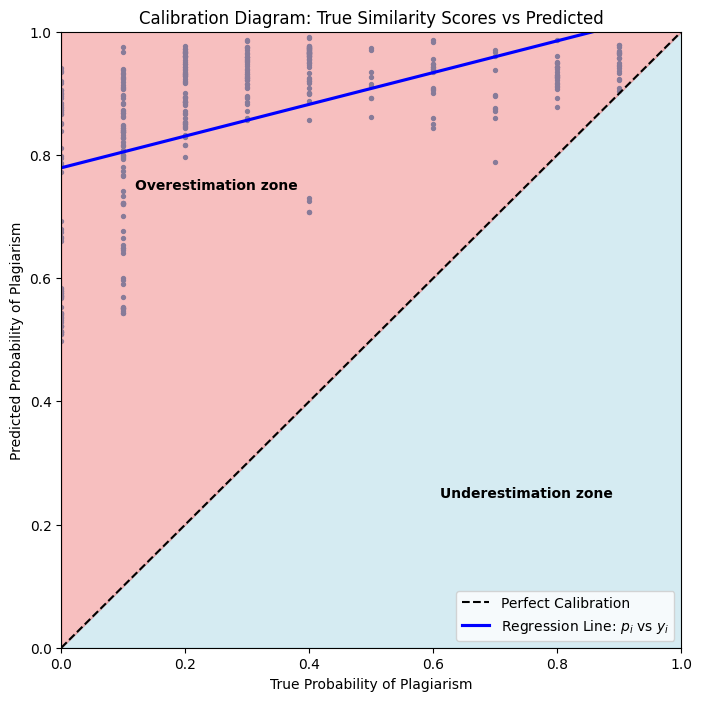

In [33]:
plot_calibration_diagram(norm_cos_similarity.cpu().numpy(), plagiarism_scores.cpu().numpy())

Well, since our baseline model is very sensible to any hint of plagiarism, let's look at the other side of the coin, and see how a naive model would perform if it alwats assumed the candidates do not copied code from LLMs, this is a "innocent until proven guilt" approach.

#### Baseline with Naive Classifier (Innocent until proven guilt)

In [34]:
naive_predictions = torch.zeros(len(plagiarism_scores))

# collect predictions
metrics.loc[1] = ["Naive 0-classifier",
                  log_loss(naive_predictions, plagiarism_scores).numpy(),
                  kl_divergence(naive_predictions, plagiarism_scores).numpy(),
                  brier_score(naive_predictions, plagiarism_scores).numpy()]

In [35]:
metrics

,Model,Log-Loss,KL Divergence,Brier Score
0,Cosine Similarity - Normalized,1.5238073,1.1052966,0.72761214
1,Naive 0-classifier,10.261124,9.842613,0.3196296


The metrics tells that the naive 0-classifier is much worse than the normalized cosine similarity between the pairs of answers. But interestingly, the Brier Score of the naive 0-classifier was better. That happens because the formula for the Brier Score in the setup where $p_i = 0, \forall i$ reduces to $\frac{1}{n}\sum_{i=1}^n 2y_i^2$. Therefore, the Brier score of the naive 0-classifier dependes solely on the distribution of the true labels, and thus, it is meaningless.

To finish the talk about baselines, let's plot the calibration diagram of the naive 0-classifier.

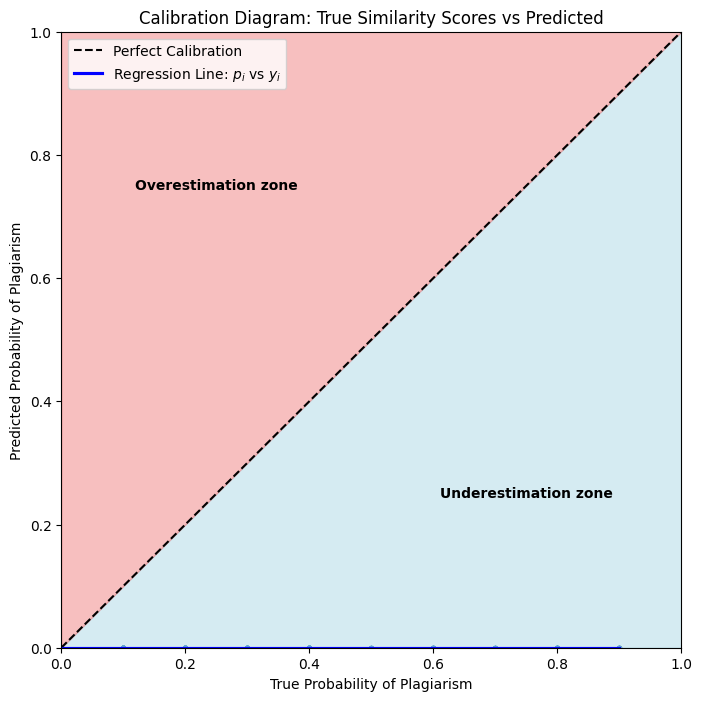

In [36]:
plot_calibration_diagram(naive_predictions.cpu().numpy(), plagiarism_scores.cpu().numpy())

## Finetuning: Classification

Now, let's construct a classifier that predicts the likelihood that the pair of texts from the candidates and the LLMs are the same. For that, we are going to fine tune a pre-trained model. We already met the `jinaai/jina-embeddings-v2-base-code` model when we were developing a baseline. However, we won't fine tune it because it is too big, and thus demand an amount of memory that is not available. Therefore, we are going to use another pretrained model: `microsoft/codebert` \[[4](https://huggingface.co/microsoft/codebert-base), [5](https://arxiv.org/abs/2002.08155)\].

codeBERT is a model for Programming and Natural Languages. The primary dataset used to train it consists of 2 million (comment, code) pairs from open source libraries. Concretely, a comment is a top-level function or method comment (e.g. docstrings in Python), and code is an entire function or method. Currently, the dataset contains Python, Javascript, Ruby, Go, Java, and PHP code \[[6](https://arxiv.org/abs/1909.09436)\]. So, it was pre-trained over texts from the main programming languages present in our dataset (visit the plots in the data analysis section). 

In spite of it not being trained over all programming languages present in the dataset, this may not be a problem because there aren't many samples from programming languages other than the ones covered in the codeBERT pre-training. Moreover, programming languages share syntax similarities and structure that may be identified anyways by codeBERT.

CodeBERT's basic architecture is the same as the RoBERTa base model. To deploy it for classification. We will take advantage of its archicteture and add a "head" on top of it, which is responsible for learning the patterns that come out the model encoder stack. Besides, the inputs of the network will be the results of the concatenation of the candidate answers and the LLM answers pairwisely.

The architecture that we will use for training is displayed below:

![codebert-architecture](../images/codeBERT-for-classification.png)

The hard part of the implementation is abstracted by the `AutoModelForSequenceClassication`. The hyperparameters and extra info about the model training is provided below:

Train/Test Split: 80%/20% (302/76 samples)

```python
num_train_epochs = 5
batch_size = 8
learning_rate = 2e-5
weight_decay = 1e-2
```

In [37]:
import torch
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments, Trainer
from transformers.trainer_utils import PredictionOutput
from transformers import AutoModelForSequenceClassification
from transformers import PreTrainedTokenizerBase

from sklearn.model_selection import train_test_split

2024-06-05 02:40:11.307092: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
model_ckpt = "microsoft/codebert-base"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# By default we must set num_labels=2 when doing binary classification with AutoModels
num_labels = 2  # [1 - plagiarism_score, plagiarism_score]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_classifier = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
def tokenize(batch: Dict[str, Any], tokenizer: PreTrainedTokenizerBase) -> Dict[str, Any]:
    return tokenizer(batch["candidate_answer"], batch["llm_answer"], padding=True, truncation=True)


def prepare_dataset(dataset):
    return {
        'input_ids': dataset['input_ids'],
        'attention_mask': dataset['attention_mask'],
        'labels': [[1 - label, label] for label in dataset['plagiarism_score']]
    }

In [40]:
# Apply tokenization
dataset_encoded = dataset.map(lambda batch: tokenize(batch, tokenizer=tokenizer), batched=True, batch_size=None)

train_size = 0.8
train_indices, test_indices = train_test_split(range(dataset_encoded["data"].num_rows), test_size=1 - train_size, random_state=42)

train_dataset = dataset_encoded["data"].select(train_indices)
test_dataset = dataset_encoded["data"].select(test_indices)

train_dataset = Dataset.from_dict(prepare_dataset(train_dataset))
test_dataset = Dataset.from_dict(prepare_dataset(test_dataset))

Map:   0%|          | 0/378 [00:00<?, ? examples/s]

In [63]:
def compute_metrics(pred: PredictionOutput):
    labels = pred.label_ids
    preds = pred.predictions
    preds = torch.sigmoid(torch.tensor(preds)).squeeze().numpy()  # guarantee that the outputs are in [0, 1]

    bce_loss = torch.nn.functional.binary_cross_entropy(torch.tensor(preds), torch.tensor(labels)).item()

    return {
        'bce_loss': bce_loss
    }

batch_size = 8
num_train_epochs = 5
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_ckpt}-finetuned-plagiarism-detector"

training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=batch_size,
    learning_rate=2e-5,
    num_train_epochs=num_train_epochs,
    weight_decay=1e-2,
    disable_tqdm=False,
    logging_steps=logging_steps,
    logging_dir='./logs',
    log_level="error",
    push_to_hub=False,
    report_to="none"  # This disables all report integrations including wandb
)

trainer = Trainer(
    model=model_classifier,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
if LOAD_PRECOMPUTED:
    model_classifier = AutoModelForSequenceClassification.from_pretrained(get_artifact_path("codebert-base-finetuned-plagiarism-detector"))
    tokenizer = AutoTokenizer.from_pretrained(get_artifact_path("codebert-base-finetuned-plagiarism-detector"))
    
    # Tokenize the input text
    test_dict = {
        "candidate_answer": data_df["candidate_answer"].iloc[test_indices].values,
        "llm_answer": data_df["llm_answer"].iloc[test_indices].values,
    }
    test_data = Dataset.from_dict(test_dict)

    test_dataset_encoded = tokenizer(test_data["candidate_answer"],
                                    test_data["llm_answer"], 
                                    return_tensors='pt', 
                                    padding=True, 
                                    truncation=True)

    # Perform inference using the loaded model
    with torch.no_grad():
        outputs = model_classifier(**test_dataset_encoded)
    
    model_predictions = torch.sigmoid(torch.tensor(outputs.logits)).squeeze()[:, 1]
else:
    trainer.train()
    predictions = trainer.predict(test_dataset)
    
    # take the second dimension of the outputs because the output is of the form
    # [1 - predicted_plagiarism_score, predicted_plagiarism_score]
    model_predictions = torch.sigmoid(torch.tensor(predictions.predictions)).squeeze()[:, 1]

The default output activation function of the codeBERT AutoModel checkpoint is the hyperbolic tangent (`tanh`), but since we want the model to output values between 0 and 1, the sigmoid function must be applied to the model predictions (this strategy was also applied when minimizing the Binary Cross-Entropy loss during the model training).

In [65]:
metrics.loc[2] = ["codeBERT-finetuned",
                  log_loss(model_predictions, plagiarism_scores[test_indices]).numpy(),
                  kl_divergence(model_predictions, plagiarism_scores[test_indices]).numpy(),
                  brier_score(model_predictions, plagiarism_scores[test_indices]).numpy()]

In [66]:
metrics

,Model,Log-Loss,KL Divergence,Brier Score
0,Cosine Similarity - Normalized,1.5238073,1.1052966,0.72761214
1,Naive 0-classifier,10.261124,9.842613,0.3196296
2,codeBERT-finetuned,0.48674372,0.048552774,0.027495582


The metrics speaks for themselves. The log-loss, KL Divergence and Brier score of the finetuned model are much better. Taking a look at the calibration diagram, it's also clear that the finetuned model is much better, even though it is less sensible towards detecting great evidences of plagiarism (i.e., it tends to underestimate a bit when the true probability of plagirism is high).

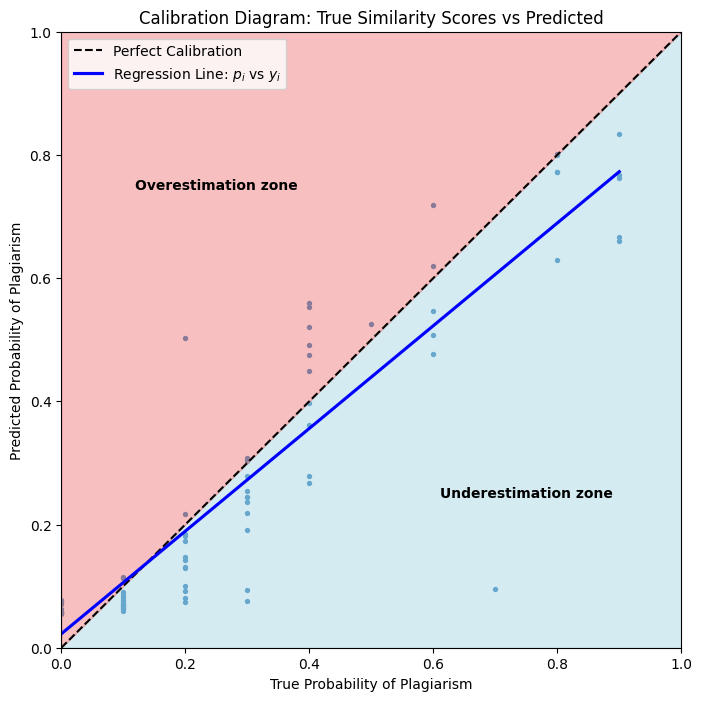

In [67]:
plot_calibration_diagram(model_predictions.cpu().numpy(), plagiarism_scores[test_indices].cpu().numpy())

## Next Steps

We can still do a few things to maybe get and even better model:

1. Use the checkpoint `jinaai/jina-embeddings-v2-base-code` instead of the `microsoft/codebert`\
`jinaai/jina-embeddings-v2-base-code` is a bigger model, that was trained over a 30 programming languages + english. Therefore, it is much better suitable for the task at hand. The only limitation to use it here is hardware. It is necessary at least 24 GB of RAM to finetune this checkpoint with the available dataset.

2. Use Siamese Networks + Triplet Loss\
Siamese networks are built to differentiate image or text representations, and on top of that, triplet loss fully embraces the objective of measuring similarity between objects. Thus, we could certainly try this approach for this problem. The attention points for tackling this problem with these ideas are: crafting a dataset with triplets that have the properties to accelerate the model learning, and hyperparameter tuning.

## References

1. **Jina Embeddings 2: 8192-Token General-Purpose Text Embeddings for Long Documents**  
Michael Günther, Jackmin Ong, Isabelle Mohr, Alaeddine Abdessalem, Tanguy Abel, Mohammad Kalim Akram, Susana Guzman, Georgios Mastrapas, Saba Sturua, Bo Wang, Maximilian Werk, Nan Wang, Han Xiao.  *2024*. arXiv: [2310.19923](https://arxiv.org/abs/2310.19923)

2. **Train Short, Test Long: Attention with Linear Biases Enables Input Length Extrapolation**  
Ofir Press, Noah A. Smith, Mike Lewis.  *2022*. arXiv: [2108.12409](https://arxiv.org/abs/2108.12409)

3. **GitHub Code Dataset**  
Hugging Face.  Available at: [https://huggingface.co/datasets/codeparrot/github-code](https://huggingface.co/datasets/codeparrot/github-code)  

4. **CodeBERT Base**  
Microsoft. Available at: [https://huggingface.co/microsoft/codebert-base](https://huggingface.co/microsoft/codebert-base)  

5. **CodeBERT: A Pre-Trained Model for Programming and Natural Languages**  
Zhangyin Feng, Daya Guo, Duyu Tang, Nan Duan, Xiaocheng Feng, Ming Gong, Linjun Shou, Bing Qin, Ting Liu, Daxin Jiang, Ming Zhou. *2020*. arXiv: [2002.08155](https://arxiv.org/abs/2002.08155)

6. **CodeSearchNet Challenge: Evaluating the State of Semantic Code Search**  
Hamel Husain, Ho-Hsiang Wu, Tiferet Gazit, Miltiadis Allamanis, Marc Brockschmidt. *2020*. arXiv: [1909.09436](https://arxiv.org/abs/1909.09436)  


